# Capstone Project

Reuben Hough

In [3]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pandas.util.testing as tm
from pandas import DataFrame
from pandas.plotting import register_matplotlib_converters
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import os
%matplotlib inline
import sys
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from numpy import random
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX as SX
from statsmodels.tsa.seasonal import seasonal_decompose as decomp
from statsmodels.tsa.stattools import adfuller
import itertools
register_matplotlib_converters()
from time import time
import math
from fbprophet import Prophet

In [6]:
Fielder = pd.read_csv('FielderStats.csv')
Pitcher = pd.read_csv('PitcherStats.csv')

In [9]:
FC = Fielder.columns.tolist()[1:]
PC = Pitcher.columns.tolist()[1:]

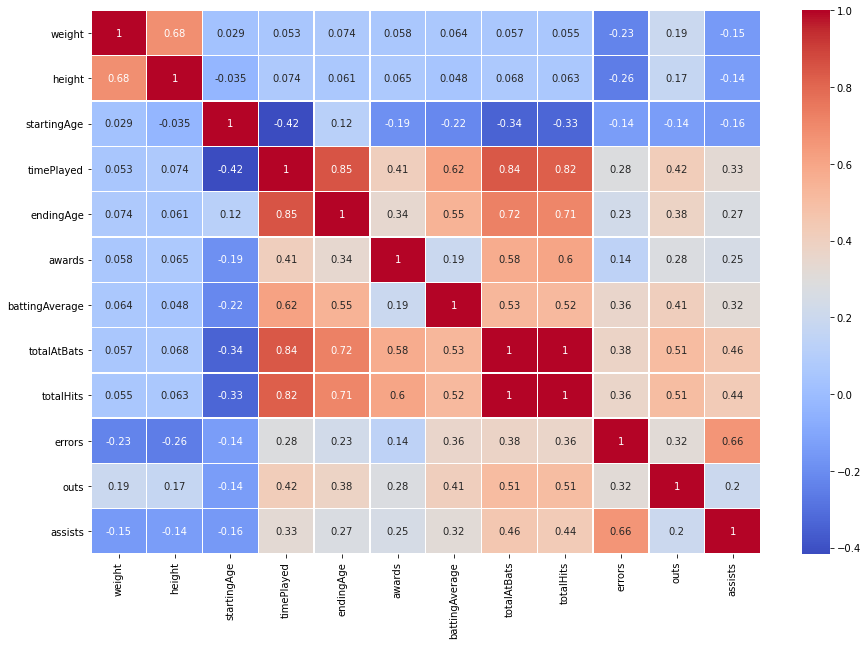

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Fielder[FC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [11]:
# Getting rid of heavily correlated columns
Fielder.drop(['timePlayed', 'totalAtBats'], axis=1, inplace=True)

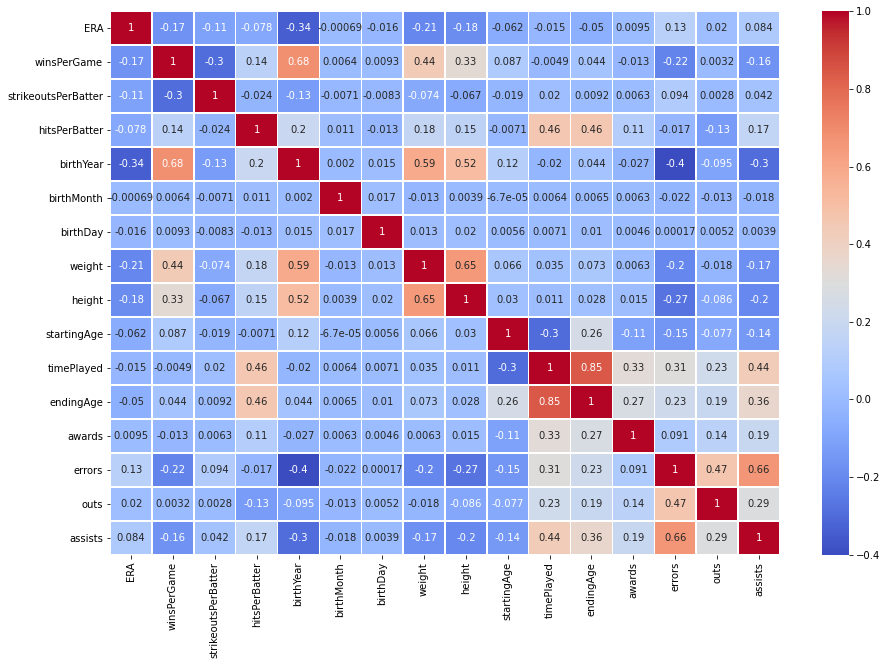

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(Pitcher[PC].corr(), cmap='coolwarm', annot=True, linewidths=.5, ax=ax);

In [13]:
Pitcher.drop(['timePlayed'], axis=1, inplace=True)